<a href="https://colab.research.google.com/github/Emilyjane994/Phenotype-paper/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Manuscript

/content/gdrive/My Drive/Manuscript


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=d6c6dfb20c3b1e6e9c55e1bdd81c389a9a1df96faaa3163f87574cf4f3ed10ff
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 28.4 MB/s eta 0:00:00


In [ ]:
import pickle
from ML_Pipeline.utils import read_data,inspection,null_values, drop_cols
from ML_Pipeline.ml_model import prepare_model_originaldata, prepare_model_smote,run_rf, classify_rf
from ML_Pipeline.evaluate_metrics import confusion_matrix,roc_curve, confusion_matrix_plot
from ML_Pipeline.lime import lime_explanation, lime_explanation_list
from ML_Pipeline.xgb import plot_feature_importance, shap_values, plot_tree_xgb, shap_values_rf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
final_report = pd.DataFrame()

## Original data

In [ ]:
# Read the initial datasets
df = read_data("input/ML_dataset.xlsx")

In [ ]:
df.head()

,ID#,Pathology,Age,Sex,cN1A status,TCRgd,Vd2,Vd2+Vg9+,Vd2CD27-,Vd2+Cx3Cr1+,...,monocytes,Nkcells,Basophils,cDC,CD56-16b,CD56b,CD56dim,classical_monocytes,int_monocytes,inflam_monocytes
0,HC1,HC,68,M,Healthy,5.07,8.99,88.2,41.7,23.70,...,1.7690,0.2684,0.0729,0.0346,48.0332,5.5944,46.3724,93.5473,3.7536,2.5068
1,HC2,HC,73,M,Healthy,3.31,4.16,82.9,84.4,19.90,...,2.0229,0.7299,0.0586,0.1710,6.3267,9.3175,83.7040,91.4568,8.0935,0.3113
2,HC3,HC,76,M,Healthy,2.29,4.90,93.3,26.3,6.11,...,0.9251,1.3357,0.0298,0.0083,4.0046,2.4337,93.3299,56.3302,37.7022,5.4843
3,HC4,HC,47,M,Healthy,4.96,52.60,66.6,35.2,40.00,...,1.0097,1.1593,0.0152,0.0022,81.9997,0.9686,16.9870,82.0701,16.1163,2.5150
4,HC5,HC,49,F,Healthy,1.82,54.00,96.4,24.6,61.70,...,1.8146,2.4483,0.0573,0.0309,15.4730,3.9977,81.4437,97.3687,2.5549,0.0546


In [ ]:
df = df.replace({
    "Pathology": {"HC":0, "IBM":1},
    "Sex":{"M":0, "F":1}
    })

In [ ]:
cols_to_exclude = ['ID#', 'cN1A status']

In [ ]:
## Exclude columns nor required in cols_to_exclude
X_train, X_test, y_train, y_test = prepare_model_originaldata(df,class_col='Pathology',
                                                 cols_to_exclude=cols_to_exclude)

computing RandomForestClassifier - Original Data 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type,95% CI lower bound,95% CI upper bound
0,RandomForestClassifier,0.729397,0.9375,0.827586,1.0,0.90566,Original Data,0.830714,0.95262


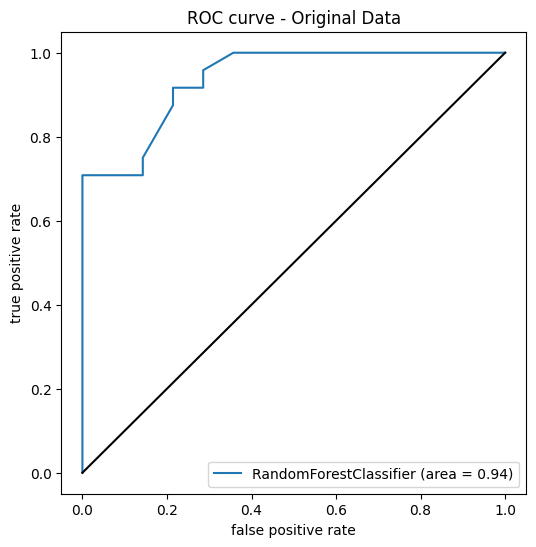

In [ ]:
models_report, conf_matrix = run_rf(X_train,y_train,X_test,y_test, 'Original Data') # change model accordingly
final_report = final_report.append(models_report, ignore_index=True)
models_report

Confusion Matrix for RandomForestClassifier :


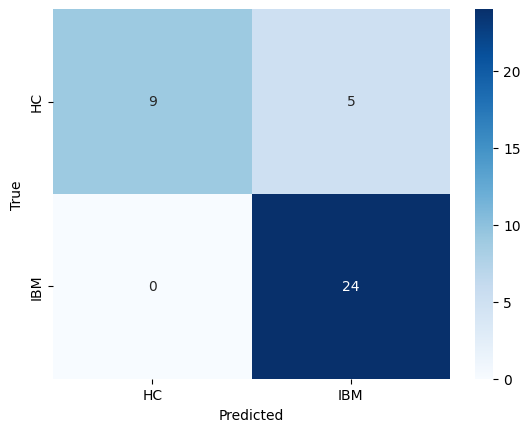

In [ ]:
for name in conf_matrix.keys():
  import seaborn as sns
  print(f"Confusion Matrix for {name} :")
  sns.heatmap(conf_matrix[name],annot=True,cmap="Blues",fmt="g", xticklabels=['HC','IBM'], yticklabels=['HC','IBM'])
  plt.show()
  print('\n')

In [ ]:
rf, y1, y2 = classify_rf(X_train, y_train,X_test,y_test)

Accuracy:  0.868421052631579
Area under the ROC curve:  0.9375
F-metric:  0.9056603773584906
 
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.83      1.00      0.91        24

    accuracy                           0.87        38
   macro avg       0.91      0.82      0.84        38
weighted avg       0.89      0.87      0.86        38

 


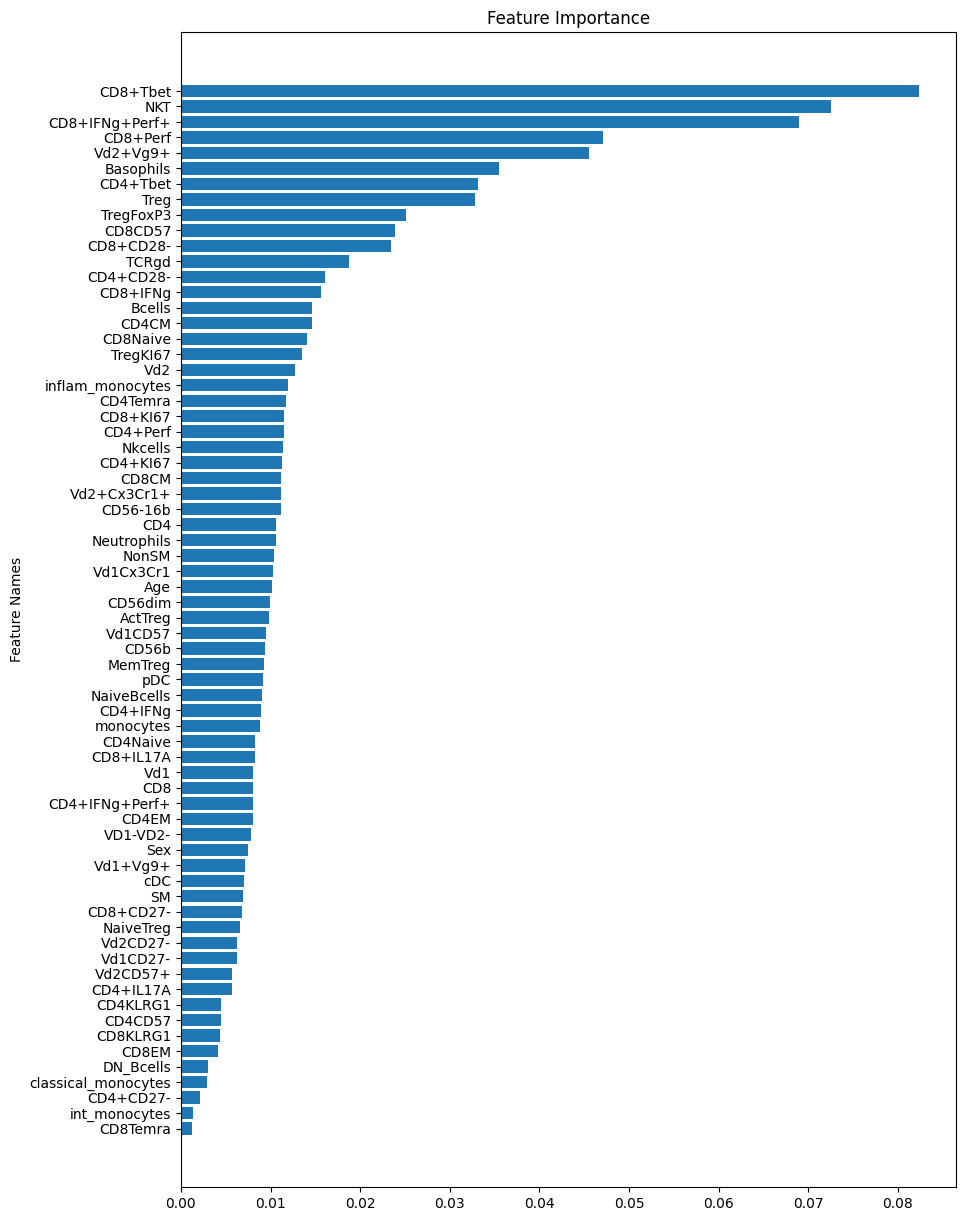

In [ ]:
plot_feature_importance(rf.feature_importances_,X_train.columns,rf)

#Plotting top20 features

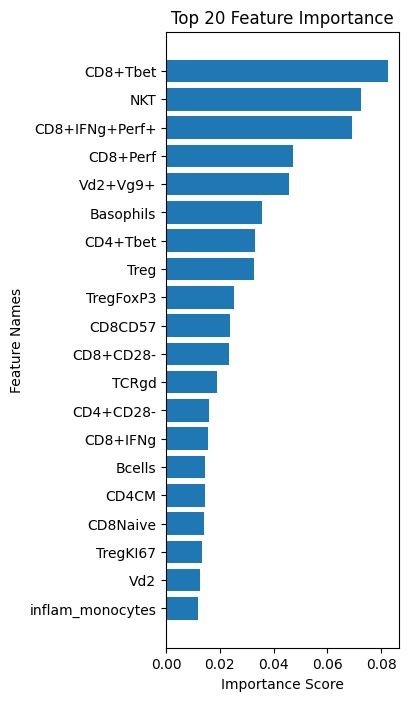

In [ ]:
def plot_feature_importance(importance, names, model, top_n=20):
    sorted_idx = importance.argsort()
    top_sorted_idx = sorted_idx[-top_n:]
    plt.figure(figsize=(3, 8))
    plt.barh(names[top_sorted_idx], model.feature_importances_[top_sorted_idx])
    plt.title(f'Top {top_n} Feature Importance')
    plt.ylabel('Feature Names')
    plt.xlabel('Importance Score')
    plt.show()

# Usage example
plot_feature_importance(rf.feature_importances_, X_train.columns, rf, top_n=20)





In [ ]:
# shap_values_rf(X_test, X_train.columns, rf)

Permutation explainer: 39it [00:29,  1.28it/s]


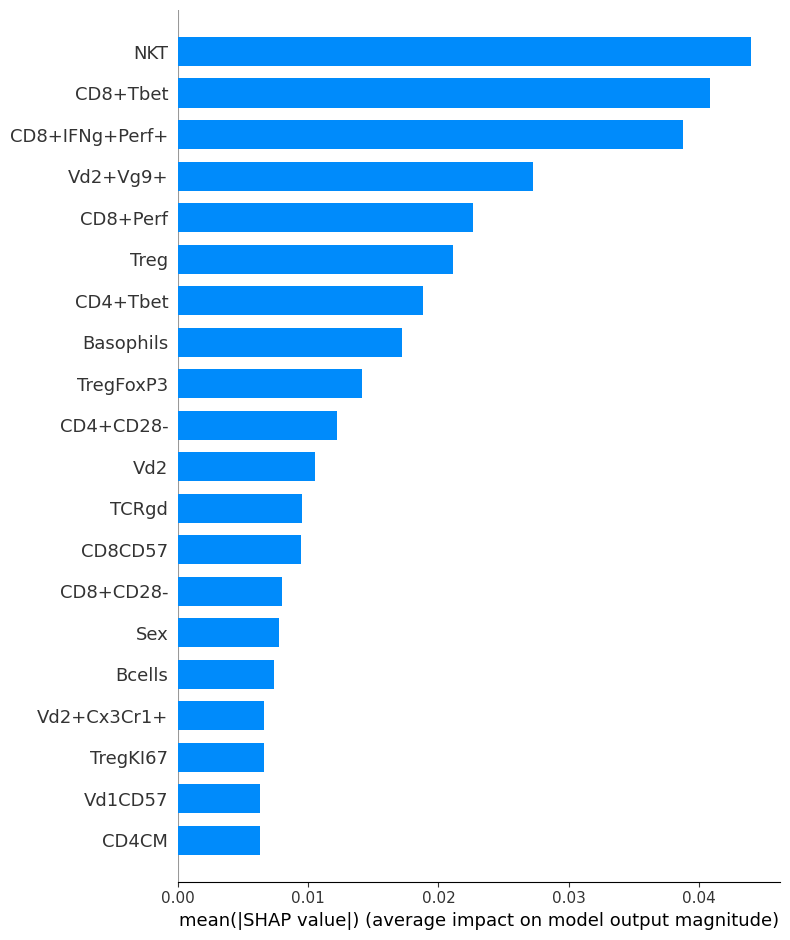

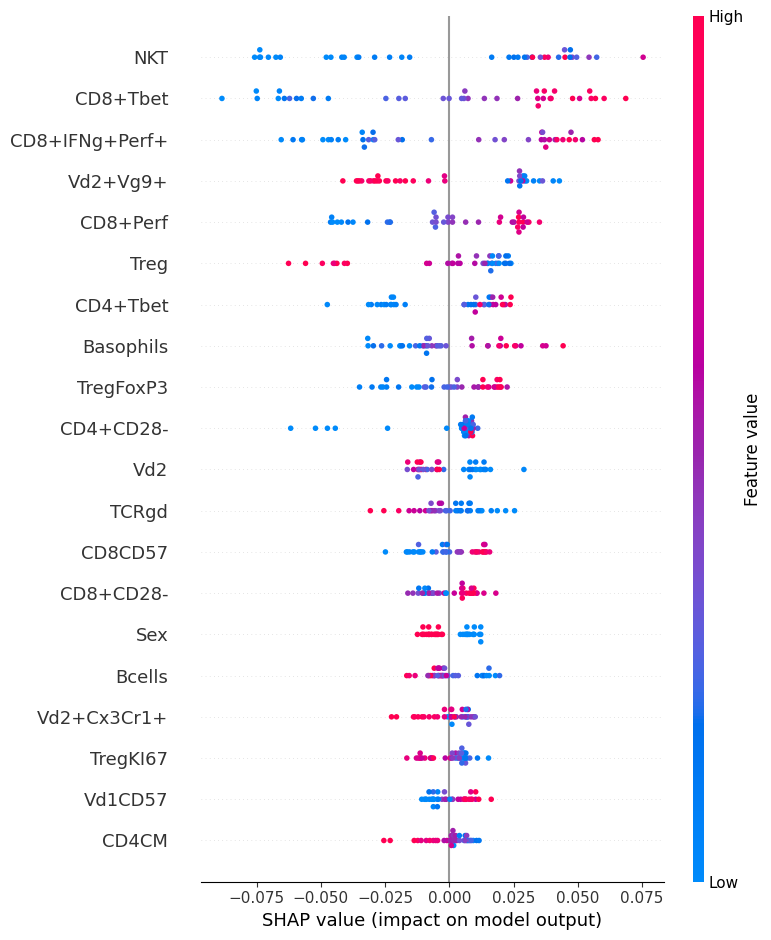

In [ ]:
shap_values_rf(X_test, X_train.columns, rf)

In [ ]:
randomIndex = 2

In [ ]:
# implement the lime function
lime_explanation(rf,X_train,X_test,['HC','IBM'],randomIndex)

In [ ]:
## check whether predicted value is correct or not
y_test.iloc[randomIndex]

1